<a href="https://colab.research.google.com/github/pjgerrits/GISRUK_Dasy/blob/main/src/Python_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dasymetric Mapping: An Introduction in Python

date: March 7, 2022

authors:
- Jeremiah J. Nieves, Geographic Data Science Lab - University of Liverpool
- Martin Fleischmann, Geographic Data Science Lab - University of Liverpool

# Overview
In this Python-based practical, we will explain what dasymetric disaggregation and modelling is. We will then proceed to walk through the basic procedures of dasymetrically modelling gridded population datasets, from census-based data, and some of the procedures to get the gridded population data ready for further uses. We will also briefly cover an "intelligent" dasymetric disaggregation which utilises machine learning to inform the redistribution of population into grids and explore potential ways of integrating other statistical modelling engines, various parameterisations, and niche applications.

## Objectives
 - Understand the differences between a "people per pixel" (ppp) and a "people per Hectare" (pph) gridded population dataset and acquire the skills to change between these population count (ppp) and population density (pph) datasets

 - Learn about dasymetric disaggregation of count data and the use of "intelligent" dasymetric disaggregation as applied to gridded population modelling.
 
## Prerequisites
Basic literacy with computers with regards to folder and file navigation, unzipping compressed folders, and basic familiarity with Python, such as running a command in the interactive window or Jupyter notebook.

# Preparation
Open up the `../GISRUK_Dasy/` folder and familiarize yourself with the structure and layout as the remainder of the instructions make reference to these folders and the files contained within them. Here the `..` refers to the directory where you have the unzipped workshop folder (`C:/Users/Jeremiah/Desktop/` in the example of Figure 1).


- `../GISRUK_Dasy/data/` contains the data we will be using throughout this exercise
- `../GISRUK_Dasy/output/` is where we will place our finalized, desirable output data
- `../GISRUK_Dasy/src/` contains the source for notebooks

![folder](https://github.com/jjniev01/GISRUK_Dasy/blob/main/Figures/figure1.png?raw=1)

## Installing Packages
We need to install the following packages prior to carrying out the practical exercise. If you have started the notebook on MyBinder, all packages are already installed:
 
- `geopandas`
- `rioxarray`
- `seaborn`
- `geocube` 

How to do that depends on your choice of a package maanager. Since we're dealing with relatively complex packages, we recommend `conda`.

```sh
conda install geopandas rioxarray seaborn geocube -c conda-forge
```

Alternatively, you may use `pip` but be careful to properly install all C-based dependencies as GDAL and GEOS. You should use this if you are using Google Colab.

```sh
pip install geopandas rioxarray seaborn geocube
```

From here on through the rest of the practical, you can either type the given commands in the interactive window, type them in a new script and running it line by line by highlighting each line and hitting `Shift+Enter`, or in the provided interactive code blocks within the Jupyter notebook (`.ipynb`) document. The Jupyter Notebook (`GISRUK_2022_Training.ipynb`) is available in the `../GISRUK_2022_Training/GISRUK_Dasy/` folder. Typing the commands in your own script will allow you to save the script for later reference and allow you to type comments by preceding your text with a `#`. 

Once the packages have been successfully installed, load the packages:

In [3]:
# Google Colab environment preparation (uncomment and run the following line)
!pip install geopandas rioxarray seaborn geocube

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 47 kB 3.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.7 MB 415 kB/s 
     |████████████████████████████████| 6.3 MB 39.7 MB/s 
     |████████████████████████████████| 19.3 MB 325 kB/s 
     |████████████████████████████████| 271 kB 43.4 MB/s 
     |████████████████████████████████| 103 kB 26.9 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=300cb21deb5be0fa3f26e2d72a6e4ccefa6c4ac9c33c67eb0482cd6995c59367
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
  Created wheel for geocube: filename=geocube-0.1.0-py3-none-any.whl size=21499 sha256=a000bc300ec00f1932725667f509af04d23e05f7b885085d751814c029591ab2
  Stored in directory: /root/.cache/pip/wheels/86/c2/4c/

In [6]:
import geopandas
import rioxarray
import seaborn
import xarray
import matplotlib.pyplot as plt

from geocube.api.core import make_geocube

# Understanding Gridded Population Datasets
There are numerous gridded population datasets with global coverage that are produced. The [popgrid consortiuum](popgrid.org) is a collaborative group of such data producers. Leyk et al. [-@Leyk2019)]gives a peer-reviewed assessment of many of these and talks about how each has different application purposes for which they are best suited. However, there are even more peer-reviewed gridded population datasets being produced every day, such as Palacios-Lopez *et al.* [-@Palacios-Lopez2022].

Regardless of the method of production the format of most of these gridded data are either in a people per pixel (ppp) format, where each pixel represents the number of people in the pixel in an *unprojected* raster (i.e. latitude and longitude), or represents population density format, where each (typically) *projected* pixel represents the number of people for a given normalising area. 

A commonly used gridded population dataset producer is [WorldPop](worldpop.org). They typically produce their datasets as ppp and people per hectare (pph), the latter being a population density measure.
For instance, while not always the case, pph is  presented in pixels that have an area of a hectare (approximately a 100m x 100m pixel). However, there is nothing stopping a people per km density in a 100m x 100m pixel. Therefore it is very important that you understand how the data is made and what units are inferred on the values within your gridded dataset!

Sticking with the WorldPop ppp and pph data example, these two datasets should look identical when opened in a GIS, but only because the density measure matches the resolution of the projected raster for pph. Again, the ppp datasets are *unprojected*, i.e. uses the wGS 84 geographic coordinate system and position is given in degrees of latitude and longitude. Conversely, the pph datasets are *projected* in an equal area coordinate system of meters from a specified origin, in most cases a Universal Transverse Mercator (UTM) projection, that is appropriate for the given country.

We’ll explore some of these differences with some data from Rwanda (three-letter iso code of "RWA").

## Spatial Characteristics of ppp and pph
In the `../data/SectionI/` folder lies our example population data rasters. Open the `RWA_pph_2002_v2.tif` and the `RWA_ppp_2002_v2.tif` population rasters You can now view the raster datasets interactively if you type (one command at a time):
using the following two commands:


In [7]:
ppp = rioxarray.open_rasterio("../data/SectionI/RWA_ppp_2002_v2.tif", masked=True)
pph = rioxarray.open_rasterio("../data/SectionI/RWA_pph_2002_v2.tif", masked=True)

RasterioIOError: ignored

In [8]:
# Use the following when working in Google Colab instead
ppp = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionI/RWA_ppp_2002_v2.tif", masked=True)
pph = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionI/RWA_pph_2002_v2.tif", masked=True)

You can now view the raster datasets if you type (one command at a time):

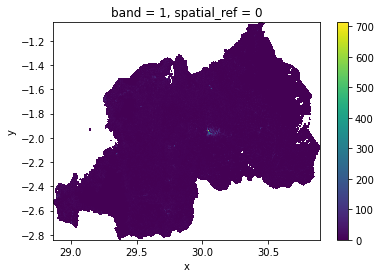

In [9]:
ppp.plot()

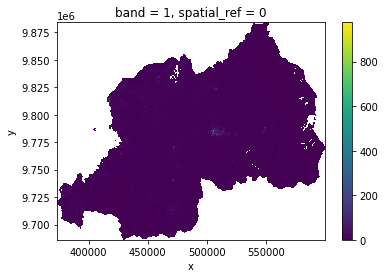

In [10]:
pph.plot()

We want some basic information regarding the two rasters we’ve loaded. We can get this by simply typing the variable name we assigned one of the rasters to and hitting `Shift+Enter`. For example, if I type `pph` and hit `Shift+Enter` I get the following output in the interactive window.

In [11]:
pph

<xarray.DataArray (band: 1, y: 1980, x: 2265)>
[4484700 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.734e+05 3.735e+05 ... 5.997e+05 5.998e+05
  * y            (y) float64 9.884e+06 9.884e+06 ... 9.686e+06 9.686e+06
    spatial_ref  int64 0
Attributes:
    SourceBandIndex:         0
    STATISTICS_COVARIANCES:  55.41262832360594
    STATISTICS_MAXIMUM:      976.42547607422
    STATISTICS_MEAN:         4.0032503010297
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       7.4439659002178
    scale_factor:            1.0
    add_offset:              0.0

Similarly if you type `ppp` and hit `Enter` we'll get the following.

In [12]:
ppp

<xarray.DataArray (band: 1, y: 2152, x: 2447)>
[5265944 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 28.86 28.86 28.86 28.86 ... 30.9 30.9 30.9 30.9
  * y            (y) float64 -1.048 -1.049 -1.049 -1.05 ... -2.839 -2.839 -2.84
    spatial_ref  int64 0
Attributes:
    SourceBandIndex:         0
    STATISTICS_COVARIANCES:  38.45201797487155
    STATISTICS_MAXIMUM:      713.57940673828
    STATISTICS_MEAN:         3.4174178740784
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       6.2009691157811
    scale_factor:            1.0
    add_offset:              0.0

You can also check coordinate systems using `.rio.crs` attribute.

In [13]:
ppp.rio.crs

CRS.from_epsg(4326)

In [14]:
pph.rio.crs

CRS.from_wkt('PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Notice how the coordinate reference systems are different and given in a standardized text format known as PROJ.4 (even if using the more updated PROJ.6 format). For the `ppp` dataset, it is the unprojected (meaning its units are in degrees of latitude and longitude) coordinate system WGS 1984. For the pph dataset, the coordinate reference system notes that it is in the datum of WGS 1984, but it is projected as a transverse Mercatorwhose origin latitude is +30° and has units in meters, that this dataset is a custom Universal Transverse Mercator (UTM) projection that lies between the “standard” UTM zones 35 and 36 (http://www.dmap.co.uk/utmworld.htm).

Also given here is information regarding the spatial resolution (resolution), the area size on the ground each pixel represents, of the rasters. We can see the ppp data has a value of (`0.0008333`,`0.0008333`) for the x and y-axes and similarly the `pph` dataset has (`100`,`100`). These values are the length and width of each pixel in the units of their coord. ref., meaning the ppp dataset has pixels with area equal to 0.0008333° x 0.0008333° and the `pph` dataset has pixels with area equal to 100m x 100x (0.1km sq also known as a “hectare”).

These differences have some implication for users. Because WGS 1984 is a spherical representation of the surface of Earth, one degree of latitude becomes smaller the further away you move from the Equator. This means that the southernmost pixel in the Rwanda ppp population dataset represents and area smaller than the northernmost pixel in the same dataset! The reverse is true for datasets north of the Equator. The pixels of the `ppp` (0.0008333°) and `pph` (100m) datasets represent approximately the same area at the Equator. Within a given dataset, the issue of unprojected pixels representing smaller areas the further from the Equator is a relatively larger problem for countries that cover a wide range of latitudes, Chile for example, if we were to calculate population densities directly from the `ppp` dataset without accounting for the above issues.

## Proper Resampling and Aggregating of pph
Let’s say you wish to have the pph population density data have a different population density per unit area to match other data, for example people per sq. km, but still have every pixel be 100m x 100m. This is a simple algebraic unit conversion. Let’s say we had a pixel with a value of 5.5 people per hectare and wanted to know the equivalent in sq. km. Given that one hectare is 0.01 sq km we use the equation:

$$\text{people per km}^2 = \frac{5.5 \text{ people}}{1 \text{ hectare}} * \frac{1 \text{ hectare}}{0.01 \text{ km}^2}$$

The second element of the equation is what is known as a _conversion factor_. Thankfully, Python and the `xarray` package allow for super simple commands for doing this sort of “Raster Math” across every pixel in the raster at once. Type and execute the following command:


In [15]:
ppk = pph / 0.01

Simple, right? Let’s see how the values changed by typing and executing the following commands in order to compare the two raster’s distribution of values. Here we’ll create two overlapping density curves (similar to histograms) of the `pph`, in blue, and the `ppk` data, in red.

    Note: xarray does not have built-in density plotting {raster} package in R has. We can do histogram or pass it via pandas to get a similar plot.

In [16]:
# import pandas

# ax = pandas.Series(pph[0].values.flatten()).plot.kde()
# pandas.Series(ppk[0].values.flatten()).plot.kde(ax=ax, color='red')
# ax.set_xlim(-10, 1000)

or by calling the two rasters themselves to look at their range of values.

In [17]:
pph.min(), pph.max()

(<xarray.DataArray ()>
 array(0.)
 Coordinates:
     spatial_ref  int64 0, <xarray.DataArray ()>
 array(976.42547607)
 Coordinates:
     spatial_ref  int64 0)

In [18]:
ppk.min(), ppk.max()

(<xarray.DataArray ()>
 array(0.)
 Coordinates:
     spatial_ref  int64 0, <xarray.DataArray ()>
 array(97642.546875)
 Coordinates:
     spatial_ref  int64 0)

We can see that the values shifted in scale to much larger ones in the `ppk` data (by a factor of 100). Additionally, this served to spread the distribution of the `pph` values across a larger range in the `ppk` data, which is reflected in the *almost* flat red line of the density plots.The red curve appears flat only because of the scale of the plot, but is actually has a slight convex curve with a local maximum around 220 on the x-axis. The pixels are still only 100m x 100m (0.01 sq km), but the units of population density in the `ppk` data are different.

This approach can be used to convert to any area unit desired for the population density; all that is needed is the correct conversion factor.

But what if you need to have your population density data at a coarser resolution to match another dataset? Let’s say you have some data on urban extents at 1 sq. km resolution and need to have your population density information at the same spatial resolution. Here we can use the `xarray` method `coarsen()`. This method takes your original raster and aggregates the pixels into larger pixels using a specified mathematical function to aggregate the many values into 1 value per new, larger pixel. Type and execute `help(pph.coarsen)` in the interactive window for more function information.

Let's aggregate the `pph` data into pixels that are actually 1 sq. km in resolution.

In [22]:
pph_1k = pph.coarsen(dict(x=10, y=10), boundary="pad").mean()

Visually compare the `pph` raster and the `pph_1k` raster by using the plot function.


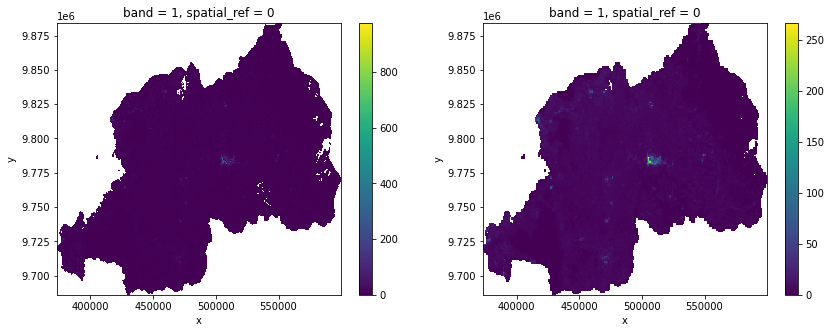

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

pph.plot(ax=axs[0])
pph_1k.plot(ax=axs[1])

You should now have a data set with a spatial resolution/cell size of 1000m x 1000m (check the layer properties to ensure). What are the units of this new raster’s values though? Because we had `xarray` take the average or mean of the input data (`pph`), every pixel in the output dataset represents the average people per hectare of the input cells. If you desired people per sq. km at 1 sq. km resolution, then the conversion procedure would also need to be done either prior to aggregation.

Note: Be aware of the modifiable areal unit problem (MAUP) when aggregating. See Openshaw [-@Openshaw1984] for more information.

Alternatively, you can resample to change the resolution of the data, although there are serious caveats with this if you resample to a smaller spatial resolution since that would be disaggregating without any corresponding finer scale information, as with dasymetric disaggregation (See Section 4), and therefore committing an _ecological fallacy_.

Let’s say you need to resample to ~300m resolution to match some projected European Space Agency Climate Change Initiative land cover data. We will use the `reproject_match()` function from the `rioxarray` package to do this. Deciding what resampling method to use, bilinear or bicubic, is based upon use and preference. See [here](http://desktop.arcgis.com/en/arcmap/latest/extensions/spatial-analyst/performing-analysis/cell-size-and-resampling-in-analysis.htm) for a visual description of how the resampling methods work. Because our data are continuous we will use bilinear interpolation.

`rioxarray` allows to have a raster that already has the desired resolution to use as a “template” for converting your input dataset. In this scenario we can just give it the landcover dataset.

Type and execute the following to load the landcover raster:

In [21]:
rwa_lc_300 = rioxarray.open_rasterio("../data/SectionI/rwa_lc_300_projected.tif")

RasterioIOError: ignored

In [ ]:
# rwa_lc_300 = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionI/rwa_lc_300_projected.tif")

Then type and execute the following to carry out the resample:

In [ ]:
from rasterio.enums import Resampling

pph_300m = pph.rio.reproject_match(rwa_lc_300, resampling=Resampling.bilinear)

Use the plot function to see how the results carried out.

In [ ]:
pph_300m.plot()

Take caution, if you do any of the above with the population count data, once you have aggregated, using `sum()`, or by resampling, they will no longer add back up to the population total of the census-based unit they were disaggregated from! That eliminates a key advantage and property of dasymetric mapping -- its "volume preserving" characteristic.

##  Going from ppp to Spatially Projected Population Density
So, we've seen how to do some manipulations with the pph-formatted data. But what if we have unprojected ppp-formatted data and we want to acqurie gridded population data where our values correspond to some populaiton density?

The key is the pixel area grid dataset that is provided with this dataset. The pixel area raster is a 0.0008333° resolution dataset whose pixel values represent the area of a given pixel in square meters. This means that if we have the spatially aligned ppp dataset, it becomes another simple algebra problem using raster math where:

$$\text{population density in pixel }i = (\text{population count}_i)/(\text{pixel area}_i)$$


First we need to get a raster where each pixel contains the value of the its area in some squared linear units. You can either try to compute area for each (spherical) pixel, or reproject the raster to a local UTM zone to work with meters.

In [ ]:
ppp_rwa = rioxarray.open_rasterio("../data/SectionI/ppp_prj_2002_RWA.tif", masked=True)

In [ ]:
# ppp_rwa = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionI/ppp_prj_2002_RWA.tif", masked=True)

We can use `pyproj` to estimate an UTM zone unless we know it a priori.

In [ ]:
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=ppp_rwa.x.min(),
        south_lat_degree=ppp_rwa.y.min(),
        east_lon_degree=ppp_rwa.x.max(),
        north_lat_degree=ppp_rwa.y.max(),
    ),
)
crs = utm_crs_list[0]

Now, we can simply reproject the grid and get estimated pixel area.

In [ ]:
ppp_rwa_utm = ppp_rwa.rio.reproject(f"{crs.auth_name}:{crs.code}")
px_area = ((ppp_rwa_utm.x[1] - ppp_rwa_utm.x[0]) ** 2) / 1_000_000

We could then get the population density per sq. km, in approx 100m x 100m pixels, by simply dividing the `ppp_rwa` by `px_area`. But, let's say we want to convert this `ppp` dataset to have density units of people per sq. mile (mi). For this we'd need a conversion factor of 1 sq. km to 0.386102 sq. mi. For each pixel $i$ the equation for its value would look like:

$$\text{ppmi} = \frac{ppp\_rwa}{px\_area_{km^2}} * \frac{1\text{ km}^2}{0.386102\text{ mi}^2}$$

We could then execute the following:

In [ ]:
ppmi = ppp_rwa_utm / px_area * (1 / 0.386102)

You should now have a population density layer, with units of people per square mile. If you desired another area unit for the density value, you could use the same equation above and modify it by simply multiplying by the correct conversion factor. Feel free to explore this dataset as before with plotting and other graphs.

# "Intelligent" Dasymetric Redistirbution 
## What is Dasymetric Redistribution?
Dasymetric redistribution is the disaggregation of values from count data a larger _source area_ to a series of, smaller, _target areas_ that lie within the given source area based upon _ancillary data_. Ancillary data is information related to the phenomena, which is being disaggregated, and is used to inform, proportionally, which target units the counts being distributed should be assigned [@Wright1936; @Eicher2001; @Mennis2003; @Mennis2006; @Mennis2009]. The ancillary data must be at the same spatial resolution of the target areas and the disaggregated values assigned to the target areas should add back up to the original value of the source area they were distributed from [@Mennis2003; @Mennis2006; @Mennis2009]. This is similar to the more simple procedure of areal reweighting (Figure 2) which redistributes count values based upon the proportional relationships between the areas of the targets to the source [@Eicher2001].

For instance, if we are disaggregating population counts from a county down to the admin units that make up the county, we could use land cover as an ancillary dataset, as shown in an example within Figure 3. This is because we know, or assume, things about the relationship between population counts and land cover, e.g. few to no people live in water (land cover class "200" in example), more people live in built land cover (land cover class "190" in example) than in agriculture land cover (land cover class "11" in example), and more people are likely to live in agriculture land cover than forest land cover (land cover class "40" in example) [@Mennis2003; @Mennis2006; @Nieves2017].

How we go about communicating this relationship mathematically is by assigning weights to the different ancillary data. This can either be done by manually assigning weights based upon expertise or theoretical concepts [@Mennis2003], or so-called “intelligent” dasymetric mapping [@Mennis2006] where the weights are determined by some statistical function or model such as linear regression (Figure 3). It is important to note that these weights are used relative to each source area. So, if a target area has a given weight, we first normalize it, if the weights in the source area do not already add up to 1, relative to all the other target areas within its source area prior to multiplying the source area count by the weights to get the final disaggregated target area counts (Figure 3).

We are going to examine a method of random forest-informed dasymetric modelling of gridded population data, put forth by Stevens *et al.* [-@Stevens2015] that uses a random forest regression, a regression tree-based machine learning method, to create the weights that inform the dasymetric redistribution of population count values from source areas (typically census-based enumeration units) to our target areas (approximately 100m resolution pixels).

##  What is a Random Forest?

Random forests (RFs) are a non-parametric modelling method that creates an ensemble model by growing many independent decision trees through random covariate selection and a sampling with replacement method called bagging [@Breiman1996; @Breiman2001]. As related to user input and parametrization, RFs do not require much, which is an attractive feature and allows it to be used on large datasets with varying attributes. A brief summary of strengths and weaknesses of RFs are presented in Table below:

|Strengths|Limits|
| --------------------- | ---------- |
|All-purpose model that performs well on most problems including those with non-linear relationships, many complex interactions of covariates, and collinearity|Covariate relationships to outcome of interest largely, but not wholly, uninterpretable since it is composed of hundreds of decision trees, i.e. considered a 'black box' method||
|Handles noisy or missing data in addition to categorical and continuous data and is robust against over training||
|Can be specified to only include the most important variables||
|Can handle extremely large and extremely small datasets||
|Can be used for either classification or regression||
|Requires little to no manual tuning of parameters||
|Scalable, i.e. can be parallelized for quicker performance||
|Internal validation estimate||

While fully understanding a RF is not necessary to utilize this data correctly, those who wish to know more can read [@Breiman1996; @Breiman2001; @Liaw2002] and the document `Classifiers and Random Forests.pdf` in the `../docs/` folder. The important concept is that we use random forests to create the weighting layer used in our dasymetric redistribution of population count data by training it at the admin unit level using unit averages of covariates and population density and then predict population density per pixel based upon pixel level covariates.

##  Dasymetric Disaggregation with a Random Forest-informed Weighting Layer

Here we will provide you with the weighting layer created by a RF and have you manually go through the process of disaggregating population count data from vector-based administrative units to ~100m pixels. Let’s start by adding our vector-based population data that is stored as a polygon shapefile. 

Execute the following:

In [ ]:
pop_shp = geopandas.read_file("../data/SectionII/adminpop.gpkg")

In [ ]:
# pop_shp = geopandas.read_file("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionII/adminpop.gpkg")

Take a bit of time to explore the attribute table of the `pop_shp` object paying attention to the `ADMINID` and `ADMINPOP` fields. The `ADMINID` field is the unique ID of each source area and the `ADMINPOP` field is the total population count for each area. If we execute the `describe()` method and call the `head()` method on the `pop_shp` object:

In [ ]:
pop_shp.head()

,GRIDCODE,ADMINID,ADMINPOP,YEARPOP,ISO,DIS_ID,geometry
0,1,1,5880,2002,RWA,15,"POLYGON ((30.06374 -1.97176, 30.06374 -1.97093..."
1,2,2,3469,2002,RWA,15,"POLYGON ((30.06124 -1.96593, 30.06124 -1.96426..."
2,3,3,3279,2002,RWA,15,"POLYGON ((30.05874 -1.96759, 30.05874 -1.96593..."
3,4,4,3340,2002,RWA,15,"POLYGON ((30.06874 -1.96926, 30.06874 -1.96843..."
4,5,5,6510,2002,RWA,15,"POLYGON ((30.06208 -1.97259, 30.06041 -1.97259..."


In [ ]:
pop_shp.describe()

,GRIDCODE,ADMINID,ADMINPOP,YEARPOP,DIS_ID
count,9192.000000,9192.000000,9192.000000,9192.0,9192.000000
mean,4596.500000,4596.500000,1031.604765,2002.0,15.796562
std,2653.646171,2653.646171,927.474141,0.0,9.008679
min,1.000000,1.000000,0.000000,2002.0,1.000000
25%,2298.750000,2298.750000,593.000000,2002.0,7.000000
50%,4596.500000,4596.500000,839.000000,2002.0,17.000000
75%,6894.250000,6894.250000,1184.250000,2002.0,23.000000
max,9192.000000,9192.000000,19500.000000,2002.0,30.000000


We can see the attribute table of the has been read in using the `geopandas` package essentially as a `pandas.DataFrame` class with attached spatial geometry data. This means anything you can do to an `pandas.DataFrame` you can use to manipulate and view the data of the `pop_shp` object. We can also see that there are six field columns here plus a column for the geometry, but we are mainly interested in ADMINID and ADMINPOP fields. Now we’ll add the prediction density layer by executing the following:

In [ ]:
rf_weight_layer = rioxarray.open_rasterio("../data/SectionII/predict_density_rf_pred_prj_2002_RWA.tif", masked=True)

In [ ]:
# rf_weight_layer = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionII/predict_density_rf_pred_prj_2002_RWA.tif", masked=True)

Get an idea of the what the weighting layer looks like by calling:

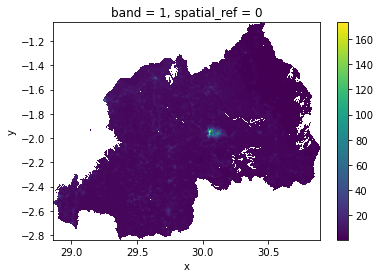

In [ ]:
rf_weight_layer.plot()

Looking at the plot legend, it is quickly apparent that that the sum of pixel values within any given source area will be much higher than 1, meaning we are not meeting one of the requirements for dasymetric weights and indicating we will need to normalize the values somehow first. This is because the RF outputs values of predicted average population density, which can have values from zero to, theoretically, infinity. 

Lets focus on normalising the weights relative to each unit. We can think of this in mathematical terms where for a given source area $i$ we divide every target pixel $j$ within that given source area by the sum of all pixels $j$ in the source area $i$. Or written as a function:

$$\text{normalised weight}_{ij} = \frac{RF\_predicted\_value_{ij}}{\sum{RF\_predicted\_value_{ij}}}$$

So, to get our normalised weighting layer we need to do two things: 1) find the sum of all pixel values within each source area of the `.shp` layer, and, 2) Divide all the pixel values of the `.tif` weighting raster by those sums. First, we’ll find the sum of weight values and create a raster of those sums that we can normalise by. So, we create a raster of zones to carry out our sum procedure within by calling the `make_geocube()` function from the`geocube` package to put the ADMINID and any other values into spatially coincident raster cells. 

In [ ]:
shp_ras = make_geocube(pop_shp, like=rf_weight_layer, measurements=["ADMINID", "ADMINPOP"])

We now have our raster where every pixel value indicates the unique ID of the source polygon area the pixel lies in. Now, let’s find the total sum of pixel level weights per admin unit. Type and execute the following to get the sum:

In [ ]:
weight_sum_table = rf_weight_layer.groupby(shp_ras["ADMINID"].astype(int)).sum()

This gives us a matrix that has one column for the unique ID of each zone and the corresponding sum of weights per zone in the second column. But this data is no longer spatial, so we need to get it back into a spatially explicit format again, specifically in a raster. So first, let’s convert the matrix to a `pandas.DataFrame` and make the names line up for a join to the shapefile. Execute the following line:

In [ ]:
weight_sum_table = weight_sum_table.to_dataframe(name="RFW_SUM")

We then join the data to the shapefile by the matching `ADMINID` value:

In [ ]:
pop_shp = pop_shp.merge(weight_sum_table[["RFW_SUM"]], on="ADMINID", how="left")

Check that the values have been transferred to the shapefile by calling:

In [ ]:
pop_shp["RFW_SUM"].head()

0    2502.027344
1    1164.864014
2    1165.417847
3    1801.993286
4    2298.033936
Name: RFW_SUM, dtype: float32

Now we’ll turn those weight sums into a raster using `make_geocube()` again:

In [ ]:
weight_sum_ras = make_geocube(pop_shp, like=rf_weight_layer, measurements=["RFW_SUM",])

Go ahead and plot the raster to see how it did.

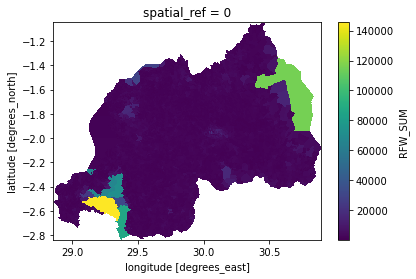

In [ ]:
weight_sum_ras["RFW_SUM"].plot()

Let’s normalise the weights; execute the following:

In [ ]:
norm_weights = rf_weight_layer / weight_sum_ras["RFW_SUM"].values

Now that we have our normalised weights in raster format we can focus on disaggregating our population count data from the `adminpop.shp` data.

Give this raster a plot to see how coarse the population data is relative to what we are about to do.

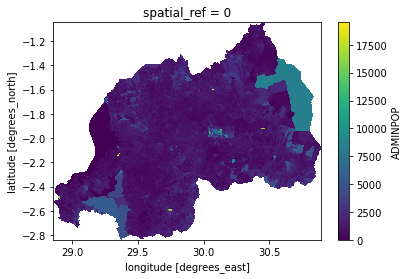

In [ ]:
shp_ras["ADMINPOP"].plot()

At last, we can disaggregate the population using the normalised weights. Execute the following:

In [ ]:
rf_disaggregation = norm_weights * shp_ras["ADMINPOP"].values

Now plot this raster to compare to the raster of the admin unit sums!

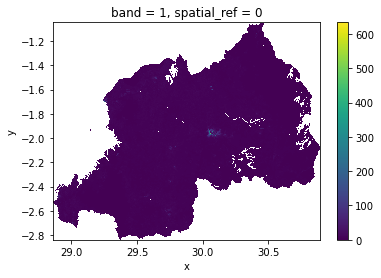

In [ ]:
rf_disaggregation.plot()

We can now perform one more check to ensure that everything went correctly. Dasymetric redistributions should ideally be “volume preserving”, meaning that all the values of the target areas should add back up to the source area they were disaggregated from. Let's add up the values using the `groupby()` method again and subtract the disaggregated sums from the admin unit values.

In [ ]:
pop_check = rf_disaggregation.groupby(shp_ras["ADMINID"].astype(int)).sum()

Now we can see what the difference is (if any) between the sum of our modelled values and the original source values:

In [ ]:
pop_difference_vector = pop_shp["ADMINPOP"] - pop_check[0][1:]
pop_difference_vector.describe().round(2)

count    9192.0
mean        0.0
std         0.0
min        -0.0
25%        -0.0
50%         0.0
75%         0.0
max         0.0
Name: ADMINPOP, dtype: float64

## Creating Your Own Dasymetric Weighting Layer

Let’s manually create a dasymetric weighting layer and see how this impacts the disaggregation. First load the `rwa_lc.tif` and view it by executing:

In [ ]:
lc_ras = rioxarray.open_rasterio("../data/SectionII/rwa_lc.tif", masked=True)

In [ ]:
# lc_ras = rioxarray.open_rasterio("https://github.com/jjniev01/GISRUK_Dasy/raw/main/data/SectionII/rwa_lc.tif", masked=True)

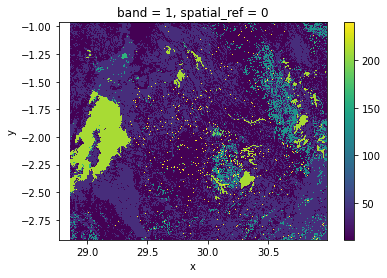

In [ ]:
lc_ras.plot()

This raster is a thematic land cover dataset where every integer value represents one of the described land cover classes in the table below. There are more classes possible in this dataset, but we only include the ones seen in Rwanda for conciseness.

|Class Number|Land Cover Description|Assigned Weight|
| --------------------- | ---------- |----------------------|
|11|Cultivated and Managed Lands| |
|40|Natural and Semi-Natural Vegetation: Woody/Trees| |
|130|Natural and Semi-Natural Vegetation: Shrubs| |
|140|Natural and Semi-Natural Vegetation: Herbaceous/Grassy| |
|160|Natural and Semi-Natural Vegetation: Aquatic| |
|190|Built Areas: Urban| |
|200|Bare Areas| |
|210|Water| |
|240|Built Areas: Rural| |

To turn this into a weighting layer, we first need to convert the land cover class values into weights. 

Using the "User Assigned Weights" column in Table 2 to record your choices, assign weighting values at your discretion based upon your beliefs of how population distribution is related to land cover classes. But remember that these values should have relative meaning amongst themselves. For instance, you may have reason to believe that water land cover (class 200) has zero population so you would want to give it a weight of “0”. You also may believe that people are five times as likely to live in built land cover (class 190) as compared to cultivated land cover (class 11) and twice as likely to live in cultivated land cover (class 11) as they are to live in forested land cover (class 40). Understanding that the lowest non-zero weight you can assign is “1”, you could then assign weights of 10, 2, and 1 to built, cultivated, and forest land cover, respectively.

Now that you have decided the weights you desire to use, we are going to create our initial weighting layer. We need to first create our reclassification dictionary. A reclassification dictionary encodes original class number as a key and its weight as a value. You just need to fill in your selected weight values, where every `x` I’ve placed should be replaced with your chosen weight. Class numbers in the code are in the same order as the above table. NOTE: The sum of your weights should add to $1.0$!


In [ ]:
rcl_mat = {
    11: x,
    40: x,
    130: x,
    140: x,
    160: x,
    190: x,
    200: x,
    210: x,
    240: x,
}

In [ ]:
rcl_mat = {
    11: 0.04,
    40: 0.06,
    130: 0.02,
    140: 0.03,
    160: 0.0,
    190: 0.65,
    200: 0.01,
    210: 0.0,
    240: 0.19,
}

Now we can reclassify to get our weights raster by running the following:

In [ ]:
lc_weight_ras = lc_ras.copy()
for k, v in rcl_mat.items():
    lc_weight_ras.values[lc_weight_ras.values==k] = v

We'll create a new *projected* zonal raster since the one we made previously was *unprojected*.


In [ ]:
shp_ras = make_geocube(pop_shp, like=lc_weight_ras, measurements=["ADMINID", "ADMINPOP"])

Like with the RF-based weighting layer, we now need to normalise this weighting layer by getting the sum of weights per admin unit, converting that to a raster, and then dividing by the sum. Type and execute the following to get the sum of weights:


In [ ]:
weight_sum_table = lc_weight_ras.groupby(shp_ras["ADMINID"].astype(int)).sum()

First, let’s convert the matrix to a `pandas.DataFrame` and make the names line up for a join to the shapefile. Execute the following two lines one after the other:

In [ ]:
weight_sum_table = weight_sum_table.to_dataframe(name="LCW_SUM")

We then join the data to the shapefile by the matching `ADMINID` value.

In [ ]:
pop_shp = pop_shp.merge(weight_sum_table[["LCW_SUM"]], on="ADMINID", how="left")

Check that the values have been transferred to the shapefile by calling:


In [ ]:
pop_shp["LCW_SUM"].head()

0    13.46
1     5.62
2     5.91
3     1.90
4    14.46
Name: LCW_SUM, dtype: float64

Now we’ll turn those weight sums into a raster using `make_geocube()` again.

In [ ]:
weight_sum_ras = make_geocube(pop_shp, like=lc_weight_ras, measurements=["LCW_SUM"])

Normalise our land cover based weights:

In [ ]:
lc_norm_weights = lc_weight_ras / weight_sum_ras["LCW_SUM"].values

We can now move to the final step of multiplying our population count raster by the weights.

In [ ]:
lc_disagg = lc_norm_weights * shp_ras["ADMINPOP"].values

Take a minute to plot and explore your dasymetrically redistributed population surface! Or save the `lc_disagg` object to a file (using the `lc_disagg.rio.to_raster("filename.tif")` command) and open it up QGIS for an interactive exploration. If you desire, you can perform the aggregation check to make sure your population count sums up properly. Additionally, you can take the `RWA_ppp_manual_2002.tif` and `RWA_ppp_LC_manual_2002.tif` and subtract them using Raster Calculator type operations to examine how each disaggregation distributed the population counts differently.

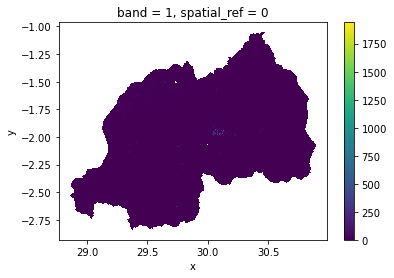

In [ ]:
lc_disagg.plot()

# Further Steps

Now that you have the basics of how to create and post-process these types of data, try exploring other implementations of dasymetric disaggregation. Some things to possibly explore:

- Utilise another statistical modelling method to create the dasymetric weights, e.g. artificial neural network [@Hopfield1988] using the `ann` package or generalised linear models [@Nelder1972] using the `glm` package in R.

- Check dasymetric areal interpolation methods available in the `tobler` package in Python.

- Read more on the limits of uncertainty in dasymetric modelling/disaggregation and one possible soultion in Nagle *et al.* [-@Nagle2014]

- Find some census-based data at two different spatial resolutions, e.g. census tracts (admin. level 3), block groups (admin. level 4), and blocks (admin. level 5) from the US census Bureau. Model gridded population by creating your weights using the coarser data (e.g. admin level 3 and 4) and then use the boundaries and counts of the spatially finest data (admin level 5) to compare the errors that get introduced by modelling with different coarsenesses of input data. Note: good error measures for this are the mean absolute error (MAE) and the root mean square error (RMSE), but it is better to calculate them using population density rather than counts as the former adjusts for the area of each admin unit. See Gaughan *et al.* [-@Gaughan2014], Reed *et al.* [-@Reed2018], and Stevens *et al.* [-@Stevens2020] for more details of looking at the errors of modelled population.

- Explore the [`popRF` package vignette](http://dx.doi.org/10.13140/RG.2.2.24822.93763) to see how you can quickly and easily construct your own random forest-informed gridded population datasets with an open online geospatial data library as well as your own input data using R.